# Performing analysis of 1 full second of simulation data acquired using the parameters of the notebook QPsimulation_5_12_2020.ipynb

#### Load the raw real and imaginary data from pickle files and filter for SNR of 50

In [1]:
import pickle

In [2]:
with open(r"E:\QPtrapperData\resParams.pkl",'rb') as f:
    resParams = pickle.load(f)

In [3]:
resParams

{'fd': 5024403707.599147,
 'f0': 5025044400.760243,
 'Qt': 3921.5686274509803,
 'Qi': 200000.0,
 'Qe': 4000.0,
 'N': 300000000,
 'q': 0.052971281788006516,
 'photonRO': 2,
 'sampleRate': 300000000.0,
 'kappa': 8051187.712429361,
 'fwhm': 1281386.3221938622,
 'diameter': 1.9607843137254901,
 'freq_shift': 349108.204087904,
 'SNR': 0.01238683948323907,
 'sigma': 6.228802712889673}

In [3]:
from scipy.constants import pi
from scipy.signal import windows, convolve

### Establish the averaging times for an SNR of 5,10,50

In [4]:
avgTime5 = 4*resParams['Qt']*5/(resParams['photonRO']*2*pi*resParams['f0'])

In [5]:
avgTime10 = 4*resParams['Qt']*10/(resParams['photonRO']*2*pi*resParams['f0'])

In [6]:
avgTime50 = 4*resParams['Qt']*50/(resParams['photonRO']*2*pi*resParams['f0'])

In [7]:
avgTime5*1e6

1.2420527699984036

In [8]:
avgTime50 * 1e6

12.420527699984037

### Let's first repeat analysis with SNR 50
generate a Hann window with length equal to averaging time and convolve with the raw data.

In [9]:
nAvg = int(max(avgTime50*resParams['sampleRate'],1))
window = windows.hann(nAvg)

In [10]:
with open(r"E:\QPtrapperData\rawSignalReal.pkl",'rb') as f:
    rhann = convolve(pickle.load(f),window,mode='same')/sum(window)

In [11]:
with open(r"E:\QPtrapperData\rawSignalImag.pkl",'rb') as f:
    ihann = convolve(pickle.load(f),window,mode='same')/sum(window)

#### Let's look at the individual Traces overs some time period

In [12]:
import matplotlib.pyplot as plt

In [13]:
import numpy as np

In [28]:
time = np.arange(resParams['N'])/resParams['sampleRate']

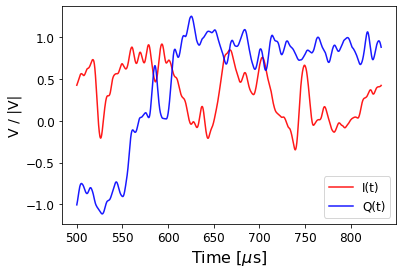

In [15]:
h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.9,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.9,label='Q(t)')
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('V / |V|',fontsize = 14)
h.tick_params(labelsize=12)
h.legend(fontsize=12)
plt.savefig(r'E:\QPtrapperData\noisySignal_SNR50.svg',format='svg')
plt.show()

### Now we'll use a machine learning package developed by scikit that implements the expectation-maximization algorithm for fitting a mixture of Gaussians.

In [14]:
from sklearn.mixture import GaussianMixture

In [15]:
theta_guess = [np.pi/2,np.pi/3,0,-np.pi/3,-np.pi/2,-2*np.pi/3,7*np.pi/6]
means_guess = np.array([np.cos(theta_guess),np.sin(theta_guess)]).T

In [16]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann[:int(rhann.size/10)],ihann[:int(ihann.size/10)]]).T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=array([[ 6.12323400e-17,  1.00000000e+00],
       [ 5.00000000e-01,  8.66025404e-01],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 6.12323400e-17, -1.00000000e+00],
       [-5.00000000e-01, -8.66025404e-01],
       [-8.66025404e-01, -5.00000000e-01]]),
                n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [18]:
estimator.converged_

True

In [19]:
estimator.means_

array([[-0.01143927,  0.97641289],
       [ 0.57668009,  0.7672065 ],
       [ 0.92977744, -0.05069134],
       [ 0.52706225, -0.78810569],
       [-0.02497126, -0.95438493],
       [-0.56706813, -0.80264213],
       [-0.90039318, -0.39858442]])

### Now we plot ellipses showing the means and std. deviations of the 7 modes.

In [19]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

In [30]:
colors = ['red','orange','yellow','green','blue','indigo','violet']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        # get the covariance matrix for the mode associated with n trapped QPs
        covariances = gmm.covariances_[n][:2,:2]
        # v are the eigenvalues of covariance matrix, aka the variances along major and minor axis of ellipse. w are the eigenvectors. Order is smallest to v to largest v
        v, w = np.linalg.eigh(covariances)
        # normalize the eigenvector associated with the smallest variance, i.e., the variance along the minor axis.
        u = w[0] / np.linalg.norm(w[0])
        # get the angle from +x axis to minor axis of ellipse
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        # v is now the diameter of the ellipse in minor, major order. It is equal to 2 std deviations.
        v = 2. *np.sqrt(v)
        # make the ellipse for mode n. Centered at mean with major and minor radius of 1 std deviation. and rotated to align to the data.
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        # now we just add the ellipses to the plot. Note that these ellipses shade the area in which all data points are within 1 std deviation of the mean.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.9)
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

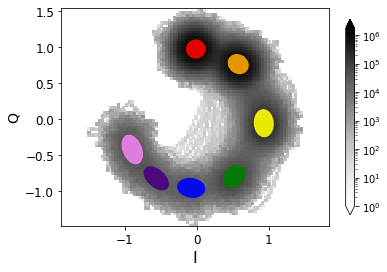

In [31]:
h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(r'E:\QPtrapperData\histModes_SNR50.svg',format='svg')
plt.show()

## Now for the real test. Let's see if it can predict the QP trap state for each point in the dataset

In [17]:
nEst = np.empty(resParams['N'],dtype=int)
seg = int(rhann.size/10)
for i in range(10):
    nEst[i*seg:(i+1)*seg] = estimator.predict(np.transpose((rhann[i*seg:(i+1)*seg],ihann[i*seg:(i+1)*seg])))

#### Let's look at a comparison between the actual number of trapped quasiparticles per the simulation, and the estimated number of trapped quasiparticles.
We first have to import the nTrapped data from pickle file

In [67]:
with open(r"E:\QPtrapperData\nTrapped.pkl",'rb') as f:
    nTrapped = pickle.load(f)

In [71]:
np.mean(nTrapped)

1.06871587

In [72]:
np.mean(nEst)

0.9247216533333333

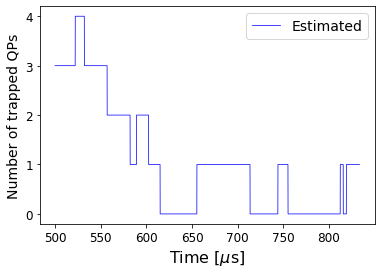

In [27]:
h = plt.subplot()
#h.plot(time[150000:250000]*1e6,nTrapped[150000:250000],'r',alpha=0.9,label='Simulation',lw=0.8)
h.plot(time[150000:250000]*1e6,nEst[150000:250000],'b',alpha=0.9,label='Estimated',lw=0.8)
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
plt.yticks([0,1,2,3,4])
h.tick_params(labelsize=12)
h.legend(fontsize=14)
#plt.savefig(r'E:\QPtrapperData\trapEstimateComparison_SNR50.svg',format='svg')
plt.show()

#### We can quantify the error by taking the mean of the difference

In [57]:
errTrap = np.diff((nEst,nTrapped),axis=0)[0]

#### errTrap is the difference, errTrap[i] = nTrapped[i] - nEst[i]. It should be positive when we underestimate and negative when we overestimate. The mean should approach 0 for large dataset unless we are somehow more prone to over or under estimating.

In [39]:
np.mean(errTrap)

0.14399421666666667

#### This would imply we are slightly more likely to underestimate. This makes sense because we can only  distinguish up to 5 trapped quasiparticles with  any accuracy. The last gaussian mode will include all occupations of 6 or more QPs. Let's look at the max of each

In [40]:
print('The actual maximum occupation is {}, while our highest occupation mode is {} or more.'.format(np.max(nTrapped),np.max(nEst)))

The actual maximum occupation is 40, while our highest occupation mode is 6 or more.


#### Let's look at the mean again, but this time we'll map the actual occupation to the range [0,6+] so as to match our estimator

In [58]:
errTrap = np.diff((nEst,np.clip(nTrapped,0,6)))[0]

In [59]:
np.mean(errTrap)

3.3333333444444444e-09

#### That's reassuring. Excluding the inability to distinguish high occupations, it looks like we're very close to a symmetric estimation.

##### Ok, now let's quantify the error. The root mean square of the difference should tell us what percent of the time we're wrong about the state.

In [60]:
np.sqrt(np.mean(errTrap**2))*100 

0.795969012448698

In [62]:
np.std(errTrap)

0.007959690124486121

In [63]:
del errTrap

In [73]:
del nTrapped

In [65]:
del rhann, ihann, h, estimator

NameError: name 'rhann' is not defined

#### According to the above, we are off in our estimate 0.8% of the time. That's pretty good.

#### What do we estimate the mean number of trapped QPs is?

In [21]:
np.mean(nEst)

0.9251512633333333

In [23]:
import scipy.stats as stats

In [24]:
stats.describe(nEst)

DescribeResult(nobs=300000000, minmax=(0, 6), mean=0.9251488866666666, variance=1.496042402486349, skewness=2.228184787676939, kurtosis=5.8955074231132425)

In [25]:
stats.find_repeats(nEst)

RepeatedResults(values=array([0., 1., 2., 3., 4., 5., 6.]), counts=array([129091931, 118278511,  28609136,  10782562,   3129189,   3468585,
         6640086], dtype=int64))

#### Now let's extract the times between subsequent trapping events

In [22]:
T_id = np.where(np.diff(nEst) > 0)

In [23]:
T_waits = np.diff(time[T_id])

### What's the mean time between trapping events?

In [24]:
np.mean(T_waits)

0.0001043493320112723

#### Let's plot some histograms, which also creates arrays we can use to fit to an exponential decay

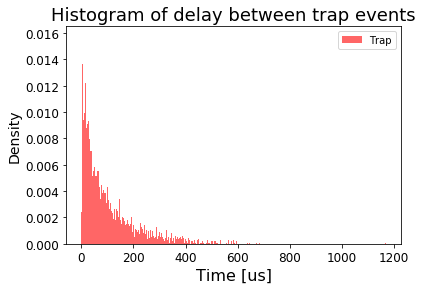

In [25]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=1000,color='r',alpha=0.6,label='Trap',density=True)
#hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
hw.set_title('Histogram of delay between trap events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
#hw.set_xlim((0,200))
hw.legend()
#plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

#### Now let's try to fit these

In [21]:
from scipy.optimize import curve_fit

In [25]:
def doubleExp(t,a1,r1,a2,r2):
    return a1*np.exp(-r1*t) + a2*np.exp(-r2*t)

In [26]:
def exp(t,a,r):
    return a*np.exp(-r*t)

In [28]:
tBinCenters = (ht[1][1:] + ht[1][:-1])/2
#rBinCenters = (hr[1][1:] + hr[1][:-1])/2

In [29]:
Tpars,Tcov = curve_fit(exp,tBinCenters[50:],ht[0][50:],[1,1/100.])

### Look at the fit results

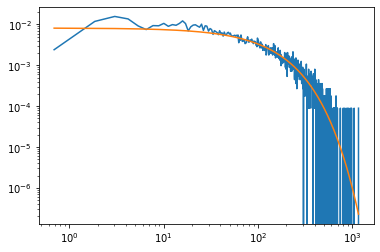

In [30]:
plt.loglog(tBinCenters,ht[0],tBinCenters,exp(tBinCenters,*Tpars))

### Let's look at the exponential decay time in us

In [31]:
1/Tpars[1]

111.40471974766349

### save a figure of trapping event rates

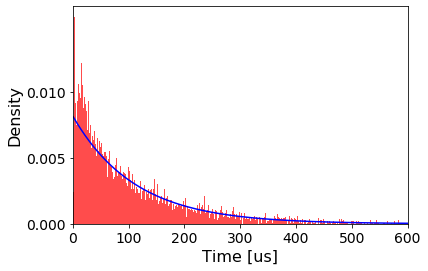

In [32]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=1000,color='r',alpha=0.7,label='Density of trap delays',density=True)
#hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
plt.plot(tBinCenters,exp(tBinCenters,*Tpars),'b',label='Exp 1')
#plt.plot(tBinCenters,doubleExp(tBinCenters,*Tpars),'k',label='Exp 1 + Exp 2')
#plt.plot(rBinCenters,Pwait(rBinCenters,*Rpars),'b',label='Fit Release')
#hw.set_title('Delay between trap events',fontsize = 18)
hw.set_xlim((0,600))
plt.yticks((0,0.005,0.01))
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 16)
hw.tick_params(labelsize=14)
#hw.legend()
plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

#### The blue line is a single expontial that is the most common rate of trapping events. The black line is another exponential added to the blue line. It accounts for the times when the trapping rate increases significantly above the average, such as when a burst event happens.

### Now let's see what the release times give us

##### run a for loop to extract the release delay times while omitting the unoccupied periods

In [33]:
pOccupied = False
diff = np.append([0],np.diff(nEst))
R_waits = np.array([])
for i in range(resParams['N']):
    if nEst[i] < 1 and pOccupied:
        pOccupied = False
    if nEst[i] > 0 and not pOccupied:
        start = time[i]
        pOccupied = True
    if diff[i] < 0:
        R_waits = np.append(R_waits,time[i]-start)
        start = time[i]

In [34]:
np.mean(R_waits)

5.936845822027399e-05

In [77]:
len(R_waits)

9542

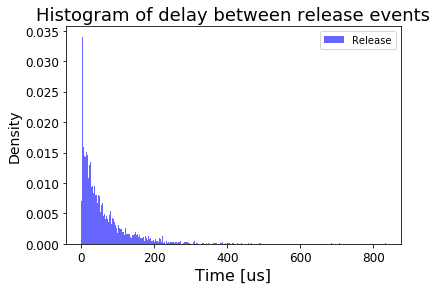

In [35]:
hw = plt.subplot()
#ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.6,label='Trap',density=True)
hr = hw.hist(R_waits*1e6,bins=1000,color='b',alpha=0.6,label='Release',density=True)
hw.set_title('Histogram of delay between release events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
#hw.set_xlim((0,200))
hw.legend()
#plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

In [36]:
rBinCenters = (hr[1][1:] + hr[1][:-1])/2

In [37]:
Rpars,Rcov = curve_fit(exp,rBinCenters[25:400],hr[0][25:400],[1,1/100.])

### What's the exponential decay time for release events?

In [38]:
1/Rpars[1]

55.8371826158612

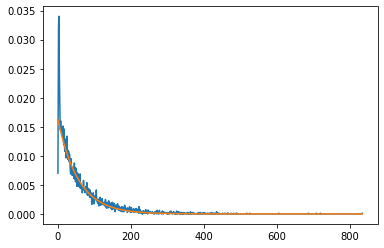

In [39]:
plt.plot(rBinCenters,hr[0],rBinCenters,exp(rBinCenters,*Rpars))

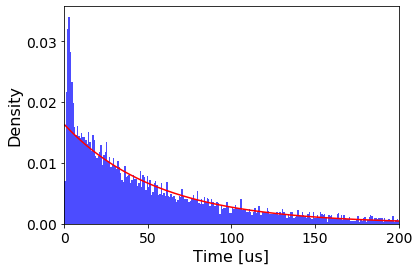

In [40]:
hw = plt.subplot()
#ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.7,label='Density of trap delays',density=True)
hr = hw.hist(R_waits*1e6,bins=1000,color='b',alpha=0.7,label='Density of release delays',density=True)
plt.plot(rBinCenters,exp(rBinCenters,*Rpars),'r',label='Exp 1')
#plt.plot(rBinCenters,doubleExp(rBinCenters,*Rpars),'k',label='Exp 1 + Exp 2')
#plt.plot(rBinCenters,Pwait(rBinCenters,*Rpars),'b',label='Fit Release')
#hw.set_title('Delay between trap events',fontsize = 18)
hw.set_xlim((0,200))
plt.yticks((0,0.01,0.02,0.03))
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 16)
hw.tick_params(labelsize=14)
#hw.legend()
plt.savefig(r'E:\QPtrapperData\releaseTimeHist.svg',format='svg')
plt.show()

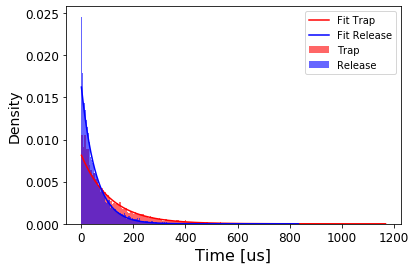

In [41]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.6,label='Trap',density=True)
hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
plt.plot(tBinCenters,exp(tBinCenters,*Tpars),'r',label='Fit Trap')
plt.plot(rBinCenters,exp(rBinCenters,*Rpars),'b',label='Fit Release')
#hw.set_title('Delay between events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
hw.legend()
plt.savefig(r'E:\QPtrapperData\eventTimeHist.svg',format='svg')
plt.show()

# For now, let's look at the autocorrelation and PSD

In [18]:
from scipy.signal import correlate

In [23]:
from scipy.optimize import curve_fit

In [19]:
from scipy.signal import welch
from scipy.signal import periodogram

In [20]:
def acorr(A):
    temp = correlate(A,A)
    temp = temp[int(temp.size/2):]
    return temp/temp[0]

In [21]:
nAC = np.mean([acorr(a) for a in nEst.reshape(10,int((nEst.size)/10))],axis=0)

In [29]:
ACpars, ACcov = curve_fit(doubleExp,time[:nAC.size],nAC,[0.4,1/0.000212,0.6,1/0.054])

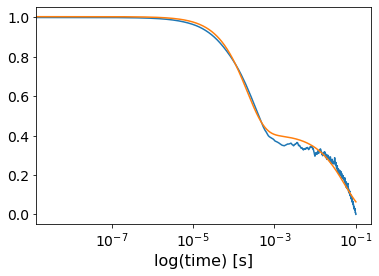

In [30]:
hw = plt.subplot()
plt.semilogx(time[:nAC.size],nAC,time[:nAC.size],doubleExp(time[:nAC.size],*ACpars))
#hw.set_xscale('log')
#hw.set_title('Delay between trap events',fontsize = 18)
#hw.set_xlim((0,200))
#plt.yticks((0,0.01,0.02,0.03))
hw.set_xlabel('log(time) [s]',fontsize = 16)
#hw.set_ylabel('Density',fontsize = 16)
hw.tick_params(labelsize=14)
#hw.legend()
plt.savefig(r'E:\QPtrapperData\autocorrelation.svg',format='svg')
plt.show()

### Below see that the fast exponential happens with a rate 1/212 microseconds

In [31]:
1/ACpars[1]

0.000212459758869963

### The slow exponential happens at rate 1/54 ms

In [32]:
1/ACpars[3]

0.053687428962168944

In [64]:
#f, nPSD = welch(nEst,resParams['sampleRate'],nperseg=1024)
f,nPSD = periodogram(nEst,resParams['sampleRate'])

MemoryError: 

In [62]:
del rhann, ihann

NameError: name 'rhann' is not defined

MemoryError: 

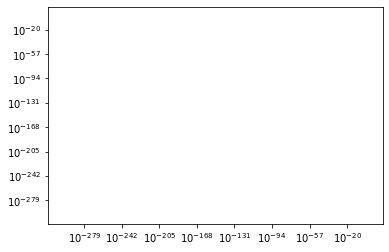

In [61]:
plt.loglog(f,nPSD)

In [161]:
def S(f,r):
    return np.sqrt(2/np.pi)* r / (1 + r**2 * f**2)

In [168]:
psdPars,psdCov = curve_fit(S,f,nPSD)

In [ ]:
plt.plot(f,nPSD,f,S(f,*psdPars))

MemoryError: 

In [136]:
f[np.argmax(nPSD)]

292968.75

In [139]:
def Lorentzian(f,f0,gamma,A):
    return A/(1 + 4*(((f-f0)/gamma)**2))

In [145]:
psdPars, psdCov = curve_fit(Lorentzian,f,nPSD)

In [152]:
psdPars

array([2.01619253e+05, 3.67954690e+01, 3.02116149e-01])

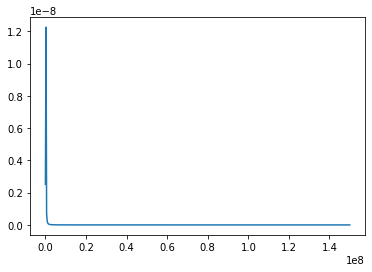

In [151]:
plt.plot(f,Lorentzian(f,*psdPars))

In [164]:
nCorr = np.mean([acorr(a) for a in nEst.reshape(100,int(nEst.size/100))],axis=0)

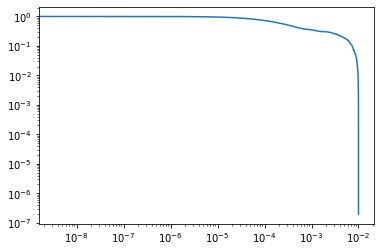

In [171]:
plt.loglog(time[:nCorr.size],nCorr)

In [94]:
resParams

{'fd': 5024403707.599147,
 'f0': 5025044400.760243,
 'Qt': 3921.5686274509803,
 'Qi': 200000.0,
 'Qe': 4000.0,
 'N': 300000000,
 'q': 0.052971281788006516,
 'photonRO': 2,
 'sampleRate': 300000000.0,
 'kappa': 8051187.712429361,
 'fwhm': 1281386.3221938622,
 'diameter': 1.9607843137254901,
 'freq_shift': 349108.204087904,
 'SNR': 0.01238683948323907,
 'sigma': 6.228802712889673}

### Let's plot the real response at occupation numbers up to 9

In [76]:
def Lorentzian(f,a,l,f0):
    return a/(1+4*(((f-f0)/l)**2)) - 1

In [85]:
colors

['red',
 'orange',
 'yellow',
 'green',
 'blue',
 'indigo',
 'violet',
 'violet',
 'violet',
 'violet']

In [86]:
resParams['f0']

5025044400.760243

In [91]:
fmin = resParams['f0'] - 9*resParams['freq_shift'] - 2*resParams['fwhm']

In [92]:
fmax = resParams['f0'] + 3*resParams['fwhm']

In [93]:
f = np.linspace(fmin,fmax,10000)

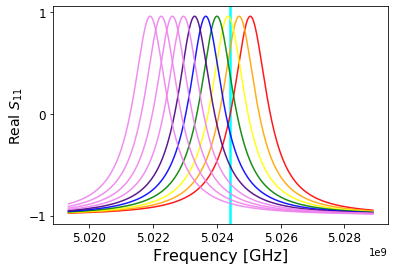

In [101]:
h = plt.subplot()
h.axvline(x=resParams['fd'],linewidth=2.5,color='cyan')
for i,c in enumerate(colors):
    f0 = resParams['f0'] - i*resParams['freq_shift']
    sig = Lorentzian(f,resParams['diameter'],resParams['fwhm'],f0)
    plt.plot(f,sig,c,lw=1.5,alpha=0.9)
h.set_xlabel('Frequency [GHz]',fontsize = 16)
h.set_ylabel('Real $S_{11}$',fontsize = 14)
h.tick_params(labelsize=12)
plt.yticks([-1,0,1])
plt.savefig(r'E:\QPtrapperData\RealResponses.svg',format='svg')
plt.show()

In [96]:
fmin

5019339654.279064

In [97]:
f[0]

5019339654.279064

In [108]:
def ImLorentzian(f,a,l,f0):
    return -2*a*((f - f0)/l)/(1+4*(((f-f0)/l)**2))

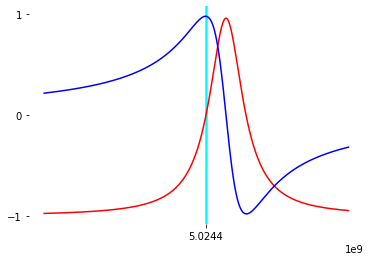

In [111]:
h = plt.subplot(frame_on=False)
h.axvline(x=resParams['fd'],linewidth=2.5,color='cyan')
f0 = resParams['f0']
sig = Lorentzian(f,resParams['diameter'],resParams['fwhm'],f0)
isig = ImLorentzian(f,resParams['diameter'],resParams['fwhm'],f0)
plt.plot(f,sig,'r',lw=1.5)
plt.plot(f,isig,'b',lw=1.5)
plt.yticks([-1,0,1])
plt.xticks((resParams['fd'],))
plt.savefig(r'E:\QPtrapperData\ZeroResponse.svg',format='svg')
plt.show()